# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

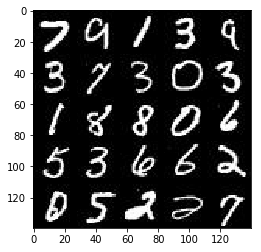

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

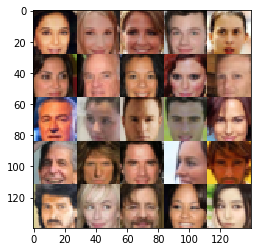

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    # alpha is set to be 0.2 here
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        #  64
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
          # leaky relu only
        x1 = tf.maximum(alpha*x1, x1)
        
        #  128
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, use_bias=False, padding='same')
          # batch normalisation and leaky relu
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        
        #  256
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, use_bias=False, padding='same')
          # batch normalisation and leaky relu
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        
        # flatten layer
        flat = tf.reshape(x3, (-1, 4*4*256))
        # output layer
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        # first fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        # reshape to 4*4*512
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
          ## batch normalisation and relu
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2*x1, x1)
#         print(x1.shape)
        # 2nd layer - conv_t - change to (7*7*256)
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, use_bias=False ,padding='valid')
          ## batch normalisation and relu
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2*x2, x2)
#         print(x2.shape)


        # 3rd layer - conv_t - change to (14*14*128)
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, use_bias=False, padding='same')
          ## batch normalisation and relu
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2*x3, x3)
        
        
#         print(x3.shape)
        # output layer - (28*28*out_channel_dim)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
#         print(logits.shape)
    return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # generator output
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    # discriminator output
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#         d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
#         g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    input_real, input_z, _ = model_inputs(data_shape[1], 
                                                      data_shape[2], 
                                                      data_shape[3], 
                                                      z_dim)
#     out_channel_dim = 1 if data_image_mode == 'L' else 3
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])#

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    
#     saver = tf.train.Saver()
#     sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

#     samples, losses = [], []
    steps = 0


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # sample random noise for Generator
                
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})



                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(steps+1, epoch_i+1),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
#                     losses.append((train_loss_d, train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 11/1... Discriminator Loss: 7.5457... Generator Loss: 0.0013
Epoch 21/1... Discriminator Loss: 4.3146... Generator Loss: 0.0286
Epoch 31/1... Discriminator Loss: 2.1037... Generator Loss: 0.2516
Epoch 41/1... Discriminator Loss: 1.7459... Generator Loss: 0.4929
Epoch 51/1... Discriminator Loss: 2.0734... Generator Loss: 0.2487
Epoch 61/1... Discriminator Loss: 1.9040... Generator Loss: 0.2827
Epoch 71/1... Discriminator Loss: 1.8212... Generator Loss: 0.3359
Epoch 81/1... Discriminator Loss: 1.6692... Generator Loss: 0.3780
Epoch 91/1... Discriminator Loss: 1.6185... Generator Loss: 0.4678
Epoch 101/1... Discriminator Loss: 1.6080... Generator Loss: 0.4268


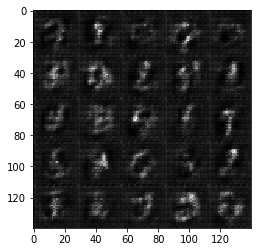

Epoch 111/1... Discriminator Loss: 1.7210... Generator Loss: 0.3414
Epoch 121/1... Discriminator Loss: 1.5749... Generator Loss: 0.4217
Epoch 131/1... Discriminator Loss: 1.6034... Generator Loss: 0.4082
Epoch 141/1... Discriminator Loss: 1.4677... Generator Loss: 0.5063
Epoch 151/1... Discriminator Loss: 1.6817... Generator Loss: 0.3511
Epoch 161/1... Discriminator Loss: 1.5147... Generator Loss: 0.4743
Epoch 171/1... Discriminator Loss: 1.7798... Generator Loss: 0.3026
Epoch 181/1... Discriminator Loss: 1.5573... Generator Loss: 0.4249
Epoch 191/1... Discriminator Loss: 1.7169... Generator Loss: 0.3356
Epoch 201/1... Discriminator Loss: 1.5302... Generator Loss: 0.4658


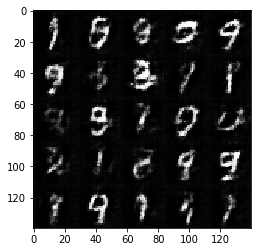

Epoch 211/1... Discriminator Loss: 1.5752... Generator Loss: 0.4176
Epoch 221/1... Discriminator Loss: 1.5296... Generator Loss: 0.4398
Epoch 231/1... Discriminator Loss: 1.6460... Generator Loss: 0.3734
Epoch 241/1... Discriminator Loss: 1.5955... Generator Loss: 0.3904
Epoch 251/1... Discriminator Loss: 1.5537... Generator Loss: 0.4461
Epoch 261/1... Discriminator Loss: 1.6249... Generator Loss: 0.3812
Epoch 271/1... Discriminator Loss: 1.4408... Generator Loss: 0.5539
Epoch 281/1... Discriminator Loss: 1.7415... Generator Loss: 0.3122
Epoch 291/1... Discriminator Loss: 1.5518... Generator Loss: 0.4146
Epoch 301/1... Discriminator Loss: 1.5061... Generator Loss: 0.5298


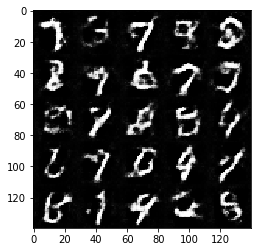

Epoch 311/1... Discriminator Loss: 1.7893... Generator Loss: 0.3060
Epoch 321/1... Discriminator Loss: 1.5516... Generator Loss: 0.4812
Epoch 331/1... Discriminator Loss: 1.5544... Generator Loss: 0.4122
Epoch 341/1... Discriminator Loss: 1.5166... Generator Loss: 0.4767
Epoch 351/1... Discriminator Loss: 1.7180... Generator Loss: 0.3244
Epoch 361/1... Discriminator Loss: 1.4030... Generator Loss: 0.6814
Epoch 371/1... Discriminator Loss: 1.6171... Generator Loss: 0.9357
Epoch 381/1... Discriminator Loss: 1.4299... Generator Loss: 0.9267
Epoch 391/1... Discriminator Loss: 1.4339... Generator Loss: 0.8974
Epoch 401/1... Discriminator Loss: 1.4275... Generator Loss: 0.8718


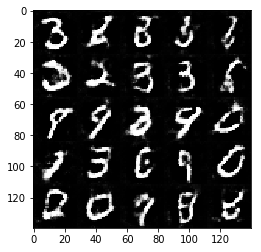

Epoch 411/1... Discriminator Loss: 1.3869... Generator Loss: 0.9611
Epoch 421/1... Discriminator Loss: 1.4342... Generator Loss: 1.0331
Epoch 431/1... Discriminator Loss: 1.4995... Generator Loss: 0.9983
Epoch 441/1... Discriminator Loss: 1.3960... Generator Loss: 0.7049
Epoch 451/1... Discriminator Loss: 1.6211... Generator Loss: 1.3585
Epoch 461/1... Discriminator Loss: 1.3777... Generator Loss: 0.7694
Epoch 471/1... Discriminator Loss: 1.3832... Generator Loss: 0.8664
Epoch 481/1... Discriminator Loss: 1.4009... Generator Loss: 0.9355
Epoch 491/1... Discriminator Loss: 1.4432... Generator Loss: 0.5553
Epoch 501/1... Discriminator Loss: 1.3741... Generator Loss: 0.8021


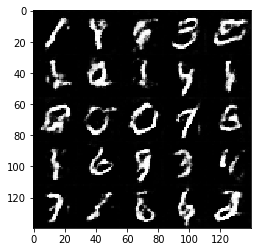

Epoch 511/1... Discriminator Loss: 1.3153... Generator Loss: 0.7346
Epoch 521/1... Discriminator Loss: 1.3416... Generator Loss: 0.8190
Epoch 531/1... Discriminator Loss: 1.4396... Generator Loss: 1.0304
Epoch 541/1... Discriminator Loss: 1.4051... Generator Loss: 0.9136
Epoch 551/1... Discriminator Loss: 1.5059... Generator Loss: 0.9923
Epoch 561/1... Discriminator Loss: 1.4272... Generator Loss: 0.7076
Epoch 571/1... Discriminator Loss: 1.4276... Generator Loss: 0.5372
Epoch 581/1... Discriminator Loss: 1.5181... Generator Loss: 1.2358
Epoch 591/1... Discriminator Loss: 1.4288... Generator Loss: 0.5905
Epoch 601/1... Discriminator Loss: 1.7148... Generator Loss: 0.3147


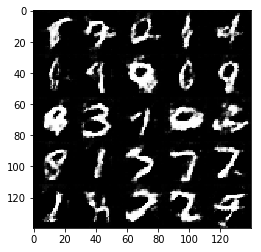

Epoch 611/1... Discriminator Loss: 1.5873... Generator Loss: 0.3945
Epoch 621/1... Discriminator Loss: 1.4481... Generator Loss: 0.5094
Epoch 631/1... Discriminator Loss: 2.1387... Generator Loss: 0.2090
Epoch 641/1... Discriminator Loss: 1.3956... Generator Loss: 0.5836
Epoch 651/1... Discriminator Loss: 1.5860... Generator Loss: 0.3788
Epoch 661/1... Discriminator Loss: 1.4760... Generator Loss: 0.4535
Epoch 671/1... Discriminator Loss: 1.4731... Generator Loss: 0.4848
Epoch 681/1... Discriminator Loss: 1.3856... Generator Loss: 0.5464
Epoch 691/1... Discriminator Loss: 1.4587... Generator Loss: 1.5073
Epoch 701/1... Discriminator Loss: 1.3224... Generator Loss: 0.7691


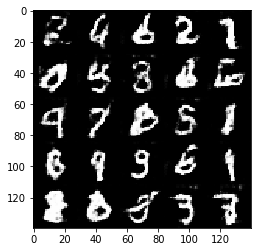

Epoch 711/1... Discriminator Loss: 1.4084... Generator Loss: 0.4831
Epoch 721/1... Discriminator Loss: 2.4688... Generator Loss: 0.1475
Epoch 731/1... Discriminator Loss: 1.3313... Generator Loss: 0.5910
Epoch 741/1... Discriminator Loss: 1.5070... Generator Loss: 1.7801
Epoch 751/1... Discriminator Loss: 1.2528... Generator Loss: 0.7201
Epoch 761/1... Discriminator Loss: 1.6975... Generator Loss: 0.3429
Epoch 771/1... Discriminator Loss: 1.3921... Generator Loss: 0.6365
Epoch 781/1... Discriminator Loss: 1.3427... Generator Loss: 1.2379
Epoch 791/1... Discriminator Loss: 1.3420... Generator Loss: 0.8347
Epoch 801/1... Discriminator Loss: 1.3336... Generator Loss: 0.7390


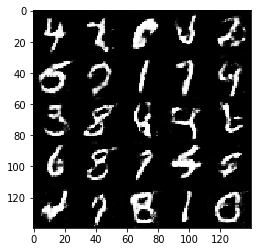

Epoch 811/1... Discriminator Loss: 1.3953... Generator Loss: 1.2939
Epoch 821/1... Discriminator Loss: 1.2526... Generator Loss: 0.7665
Epoch 831/1... Discriminator Loss: 2.1155... Generator Loss: 0.1983
Epoch 841/1... Discriminator Loss: 1.3527... Generator Loss: 0.7549
Epoch 851/1... Discriminator Loss: 1.3136... Generator Loss: 0.7814
Epoch 861/1... Discriminator Loss: 1.2462... Generator Loss: 1.1127
Epoch 871/1... Discriminator Loss: 1.3555... Generator Loss: 0.7525
Epoch 881/1... Discriminator Loss: 1.3086... Generator Loss: 0.8662
Epoch 891/1... Discriminator Loss: 1.3059... Generator Loss: 0.9239
Epoch 901/1... Discriminator Loss: 1.2393... Generator Loss: 1.0438


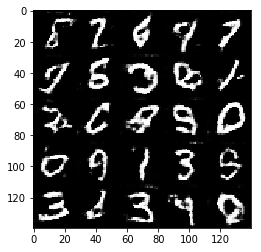

Epoch 911/1... Discriminator Loss: 1.7731... Generator Loss: 1.5118
Epoch 921/1... Discriminator Loss: 1.3665... Generator Loss: 0.5938
Epoch 931/1... Discriminator Loss: 1.3305... Generator Loss: 0.5455
Epoch 941/2... Discriminator Loss: 1.3068... Generator Loss: 0.5935
Epoch 951/2... Discriminator Loss: 1.8446... Generator Loss: 0.2802
Epoch 961/2... Discriminator Loss: 1.3613... Generator Loss: 0.5718
Epoch 971/2... Discriminator Loss: 1.5656... Generator Loss: 0.4060
Epoch 981/2... Discriminator Loss: 1.4729... Generator Loss: 0.4389
Epoch 991/2... Discriminator Loss: 1.6039... Generator Loss: 1.5368
Epoch 1001/2... Discriminator Loss: 1.2991... Generator Loss: 0.8966


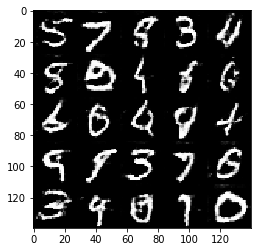

Epoch 1011/2... Discriminator Loss: 1.3539... Generator Loss: 1.0960
Epoch 1021/2... Discriminator Loss: 1.6112... Generator Loss: 0.3776
Epoch 1031/2... Discriminator Loss: 1.7110... Generator Loss: 0.3430
Epoch 1041/2... Discriminator Loss: 1.1323... Generator Loss: 0.9105
Epoch 1051/2... Discriminator Loss: 1.3400... Generator Loss: 0.6720
Epoch 1061/2... Discriminator Loss: 1.5615... Generator Loss: 0.3936
Epoch 1071/2... Discriminator Loss: 1.7899... Generator Loss: 0.3104
Epoch 1081/2... Discriminator Loss: 1.7467... Generator Loss: 0.3197
Epoch 1091/2... Discriminator Loss: 1.4323... Generator Loss: 0.4799
Epoch 1101/2... Discriminator Loss: 1.1954... Generator Loss: 0.6448


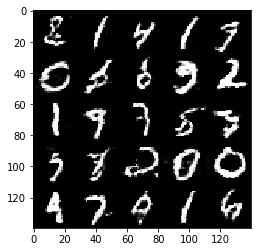

Epoch 1111/2... Discriminator Loss: 1.2844... Generator Loss: 0.7232
Epoch 1121/2... Discriminator Loss: 1.2831... Generator Loss: 0.6838
Epoch 1131/2... Discriminator Loss: 1.9970... Generator Loss: 0.2356
Epoch 1141/2... Discriminator Loss: 1.1614... Generator Loss: 0.8094
Epoch 1151/2... Discriminator Loss: 1.5358... Generator Loss: 0.9498
Epoch 1161/2... Discriminator Loss: 1.0679... Generator Loss: 1.3156
Epoch 1171/2... Discriminator Loss: 1.2310... Generator Loss: 0.7932
Epoch 1181/2... Discriminator Loss: 1.3488... Generator Loss: 0.5153
Epoch 1191/2... Discriminator Loss: 1.8619... Generator Loss: 0.3007
Epoch 1201/2... Discriminator Loss: 1.4830... Generator Loss: 0.4462


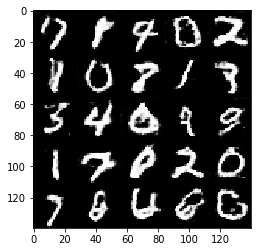

Epoch 1211/2... Discriminator Loss: 1.2161... Generator Loss: 1.2957
Epoch 1221/2... Discriminator Loss: 0.9572... Generator Loss: 1.4793
Epoch 1231/2... Discriminator Loss: 1.1401... Generator Loss: 0.9296
Epoch 1241/2... Discriminator Loss: 1.2380... Generator Loss: 0.9338
Epoch 1251/2... Discriminator Loss: 0.9680... Generator Loss: 1.1102
Epoch 1261/2... Discriminator Loss: 1.2043... Generator Loss: 1.5088
Epoch 1271/2... Discriminator Loss: 1.1500... Generator Loss: 1.2534
Epoch 1281/2... Discriminator Loss: 1.2228... Generator Loss: 0.6549
Epoch 1291/2... Discriminator Loss: 1.4863... Generator Loss: 0.5024
Epoch 1301/2... Discriminator Loss: 1.2934... Generator Loss: 0.5793


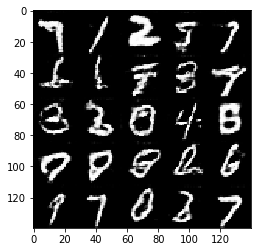

Epoch 1311/2... Discriminator Loss: 1.5405... Generator Loss: 0.3967
Epoch 1321/2... Discriminator Loss: 1.5969... Generator Loss: 0.3892
Epoch 1331/2... Discriminator Loss: 1.4529... Generator Loss: 0.4763
Epoch 1341/2... Discriminator Loss: 1.1661... Generator Loss: 1.6715
Epoch 1351/2... Discriminator Loss: 1.5844... Generator Loss: 0.3779
Epoch 1361/2... Discriminator Loss: 1.4281... Generator Loss: 0.4720
Epoch 1371/2... Discriminator Loss: 1.4869... Generator Loss: 0.4402
Epoch 1381/2... Discriminator Loss: 1.4462... Generator Loss: 0.4998
Epoch 1391/2... Discriminator Loss: 1.1919... Generator Loss: 1.3324
Epoch 1401/2... Discriminator Loss: 1.0771... Generator Loss: 1.0673


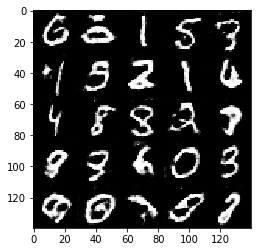

Epoch 1411/2... Discriminator Loss: 2.2859... Generator Loss: 0.1847
Epoch 1421/2... Discriminator Loss: 1.2827... Generator Loss: 0.5913
Epoch 1431/2... Discriminator Loss: 1.4190... Generator Loss: 1.0117
Epoch 1441/2... Discriminator Loss: 1.3870... Generator Loss: 0.5509
Epoch 1451/2... Discriminator Loss: 2.0922... Generator Loss: 0.2110
Epoch 1461/2... Discriminator Loss: 1.3504... Generator Loss: 0.5101
Epoch 1471/2... Discriminator Loss: 1.8227... Generator Loss: 0.3000
Epoch 1481/2... Discriminator Loss: 1.1668... Generator Loss: 0.8280
Epoch 1491/2... Discriminator Loss: 1.5864... Generator Loss: 0.6889
Epoch 1501/2... Discriminator Loss: 1.4454... Generator Loss: 1.9161


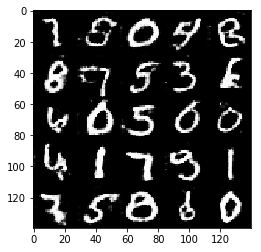

Epoch 1511/2... Discriminator Loss: 1.8192... Generator Loss: 0.2935
Epoch 1521/2... Discriminator Loss: 1.7377... Generator Loss: 0.3406
Epoch 1531/2... Discriminator Loss: 1.5650... Generator Loss: 0.3876
Epoch 1541/2... Discriminator Loss: 1.7722... Generator Loss: 0.3184
Epoch 1551/2... Discriminator Loss: 0.9517... Generator Loss: 1.1780
Epoch 1561/2... Discriminator Loss: 1.8377... Generator Loss: 0.3085
Epoch 1571/2... Discriminator Loss: 1.4319... Generator Loss: 0.4889
Epoch 1581/2... Discriminator Loss: 0.8372... Generator Loss: 2.4752
Epoch 1591/2... Discriminator Loss: 1.2715... Generator Loss: 1.2479
Epoch 1601/2... Discriminator Loss: 0.9437... Generator Loss: 1.2675


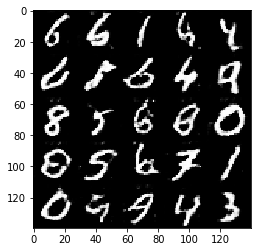

Epoch 1611/2... Discriminator Loss: 1.1993... Generator Loss: 2.2502
Epoch 1621/2... Discriminator Loss: 1.9343... Generator Loss: 0.2815
Epoch 1631/2... Discriminator Loss: 1.6662... Generator Loss: 0.3422
Epoch 1641/2... Discriminator Loss: 2.5581... Generator Loss: 0.1392
Epoch 1651/2... Discriminator Loss: 1.7002... Generator Loss: 0.3487
Epoch 1661/2... Discriminator Loss: 1.6746... Generator Loss: 0.3782
Epoch 1671/2... Discriminator Loss: 1.7139... Generator Loss: 0.3403
Epoch 1681/2... Discriminator Loss: 1.6433... Generator Loss: 0.3686
Epoch 1691/2... Discriminator Loss: 1.3468... Generator Loss: 0.6077
Epoch 1701/2... Discriminator Loss: 1.6663... Generator Loss: 0.3790


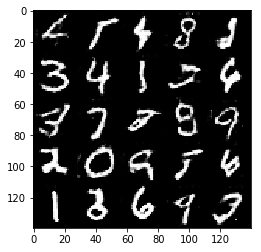

Epoch 1711/2... Discriminator Loss: 1.5544... Generator Loss: 0.4141
Epoch 1721/2... Discriminator Loss: 1.0332... Generator Loss: 1.6564
Epoch 1731/2... Discriminator Loss: 1.2422... Generator Loss: 1.5665
Epoch 1741/2... Discriminator Loss: 1.0546... Generator Loss: 1.1048
Epoch 1751/2... Discriminator Loss: 0.9402... Generator Loss: 1.2463
Epoch 1761/2... Discriminator Loss: 0.9617... Generator Loss: 1.3181
Epoch 1771/2... Discriminator Loss: 1.1503... Generator Loss: 1.9842
Epoch 1781/2... Discriminator Loss: 1.0736... Generator Loss: 1.4567
Epoch 1791/2... Discriminator Loss: 1.3042... Generator Loss: 0.5453
Epoch 1801/2... Discriminator Loss: 0.9014... Generator Loss: 1.2227


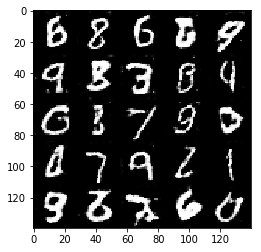

Epoch 1811/2... Discriminator Loss: 1.0342... Generator Loss: 0.8218
Epoch 1821/2... Discriminator Loss: 1.5856... Generator Loss: 1.8831
Epoch 1831/2... Discriminator Loss: 1.2349... Generator Loss: 0.6985
Epoch 1841/2... Discriminator Loss: 0.9774... Generator Loss: 1.5636
Epoch 1851/2... Discriminator Loss: 1.1054... Generator Loss: 0.7304
Epoch 1861/2... Discriminator Loss: 1.3389... Generator Loss: 0.5362
Epoch 1871/2... Discriminator Loss: 1.4421... Generator Loss: 0.4768


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2

# tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 11/1... Discriminator Loss: 4.4603... Generator Loss: 0.0892
Epoch 21/1... Discriminator Loss: 3.8050... Generator Loss: 0.1870
Epoch 31/1... Discriminator Loss: 2.7809... Generator Loss: 0.1612
Epoch 41/1... Discriminator Loss: 2.0663... Generator Loss: 0.3652
Epoch 51/1... Discriminator Loss: 2.5242... Generator Loss: 0.2274
Epoch 61/1... Discriminator Loss: 2.0095... Generator Loss: 0.3179
Epoch 71/1... Discriminator Loss: 1.8091... Generator Loss: 0.5428
Epoch 81/1... Discriminator Loss: 1.7958... Generator Loss: 0.5180
Epoch 91/1... Discriminator Loss: 1.6868... Generator Loss: 0.6032
Epoch 101/1... Discriminator Loss: 1.7922... Generator Loss: 0.3682


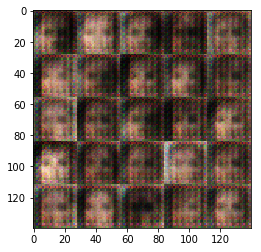

Epoch 111/1... Discriminator Loss: 1.6070... Generator Loss: 0.5673
Epoch 121/1... Discriminator Loss: 1.6938... Generator Loss: 0.4423
Epoch 131/1... Discriminator Loss: 1.5439... Generator Loss: 0.7267
Epoch 141/1... Discriminator Loss: 1.5789... Generator Loss: 0.6129
Epoch 151/1... Discriminator Loss: 1.5459... Generator Loss: 0.7115
Epoch 161/1... Discriminator Loss: 1.6104... Generator Loss: 0.7676
Epoch 171/1... Discriminator Loss: 1.6503... Generator Loss: 0.5003
Epoch 181/1... Discriminator Loss: 1.5608... Generator Loss: 0.5805
Epoch 191/1... Discriminator Loss: 1.6899... Generator Loss: 0.8901
Epoch 201/1... Discriminator Loss: 1.5565... Generator Loss: 0.5267


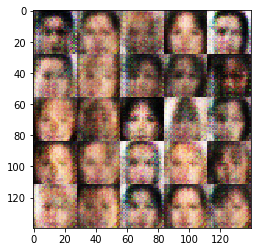

Epoch 211/1... Discriminator Loss: 1.5701... Generator Loss: 0.5978
Epoch 221/1... Discriminator Loss: 1.6301... Generator Loss: 0.5646
Epoch 231/1... Discriminator Loss: 1.5695... Generator Loss: 0.5009
Epoch 241/1... Discriminator Loss: 1.5976... Generator Loss: 0.7786
Epoch 251/1... Discriminator Loss: 1.5874... Generator Loss: 0.6633
Epoch 261/1... Discriminator Loss: 1.5591... Generator Loss: 0.7601
Epoch 271/1... Discriminator Loss: 1.5935... Generator Loss: 0.7121
Epoch 281/1... Discriminator Loss: 1.5448... Generator Loss: 0.6563
Epoch 291/1... Discriminator Loss: 1.5703... Generator Loss: 0.7233
Epoch 301/1... Discriminator Loss: 1.5390... Generator Loss: 0.6982


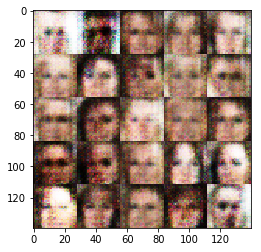

Epoch 311/1... Discriminator Loss: 1.6294... Generator Loss: 0.4604
Epoch 321/1... Discriminator Loss: 1.5187... Generator Loss: 0.7344
Epoch 331/1... Discriminator Loss: 1.5019... Generator Loss: 0.7082
Epoch 341/1... Discriminator Loss: 1.4621... Generator Loss: 0.6952
Epoch 351/1... Discriminator Loss: 1.5039... Generator Loss: 0.7273
Epoch 361/1... Discriminator Loss: 1.4540... Generator Loss: 0.6550
Epoch 371/1... Discriminator Loss: 1.5743... Generator Loss: 0.5383
Epoch 381/1... Discriminator Loss: 1.5253... Generator Loss: 0.5861
Epoch 391/1... Discriminator Loss: 1.5165... Generator Loss: 0.5636
Epoch 401/1... Discriminator Loss: 1.5404... Generator Loss: 0.6129


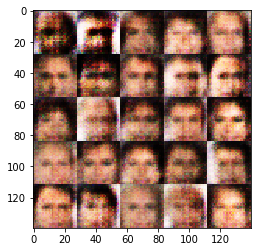

Epoch 411/1... Discriminator Loss: 1.5350... Generator Loss: 0.7212
Epoch 421/1... Discriminator Loss: 1.5285... Generator Loss: 0.5755
Epoch 431/1... Discriminator Loss: 1.4891... Generator Loss: 0.6355
Epoch 441/1... Discriminator Loss: 1.5419... Generator Loss: 0.6521
Epoch 451/1... Discriminator Loss: 1.5348... Generator Loss: 0.5388
Epoch 461/1... Discriminator Loss: 1.5746... Generator Loss: 0.8923
Epoch 471/1... Discriminator Loss: 1.5274... Generator Loss: 0.7591
Epoch 481/1... Discriminator Loss: 1.4549... Generator Loss: 0.6742
Epoch 491/1... Discriminator Loss: 1.4870... Generator Loss: 0.6935
Epoch 501/1... Discriminator Loss: 1.4639... Generator Loss: 0.7197


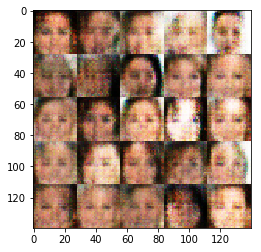

Epoch 511/1... Discriminator Loss: 1.4938... Generator Loss: 0.6061
Epoch 521/1... Discriminator Loss: 1.5692... Generator Loss: 0.5231
Epoch 531/1... Discriminator Loss: 1.4628... Generator Loss: 0.8310
Epoch 541/1... Discriminator Loss: 1.4657... Generator Loss: 0.7650
Epoch 551/1... Discriminator Loss: 1.4663... Generator Loss: 0.6505
Epoch 561/1... Discriminator Loss: 1.4740... Generator Loss: 0.6792
Epoch 571/1... Discriminator Loss: 1.5435... Generator Loss: 0.5073
Epoch 581/1... Discriminator Loss: 1.4719... Generator Loss: 0.7330
Epoch 591/1... Discriminator Loss: 1.5957... Generator Loss: 0.4910
Epoch 601/1... Discriminator Loss: 1.5120... Generator Loss: 0.5753


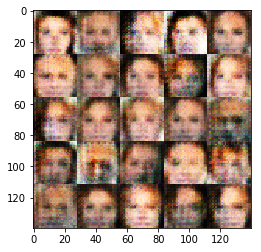

Epoch 611/1... Discriminator Loss: 1.5514... Generator Loss: 0.6469
Epoch 621/1... Discriminator Loss: 1.4528... Generator Loss: 0.8505
Epoch 631/1... Discriminator Loss: 1.4810... Generator Loss: 0.9486
Epoch 641/1... Discriminator Loss: 1.4940... Generator Loss: 0.7438
Epoch 651/1... Discriminator Loss: 1.5412... Generator Loss: 0.5773
Epoch 661/1... Discriminator Loss: 1.4483... Generator Loss: 0.6709
Epoch 671/1... Discriminator Loss: 1.4769... Generator Loss: 0.6079
Epoch 681/1... Discriminator Loss: 1.5575... Generator Loss: 0.4822
Epoch 691/1... Discriminator Loss: 1.4537... Generator Loss: 0.6196
Epoch 701/1... Discriminator Loss: 1.4652... Generator Loss: 0.6976


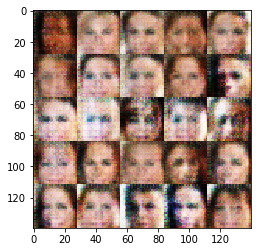

Epoch 711/1... Discriminator Loss: 1.4562... Generator Loss: 0.6033
Epoch 721/1... Discriminator Loss: 1.4840... Generator Loss: 0.6899
Epoch 731/1... Discriminator Loss: 1.5021... Generator Loss: 0.5696
Epoch 741/1... Discriminator Loss: 1.4298... Generator Loss: 0.7044
Epoch 751/1... Discriminator Loss: 1.4545... Generator Loss: 0.6626
Epoch 761/1... Discriminator Loss: 1.4549... Generator Loss: 0.6903
Epoch 771/1... Discriminator Loss: 1.4667... Generator Loss: 0.6644
Epoch 781/1... Discriminator Loss: 1.4804... Generator Loss: 0.6185
Epoch 791/1... Discriminator Loss: 1.4334... Generator Loss: 0.6049
Epoch 801/1... Discriminator Loss: 1.4721... Generator Loss: 0.7814


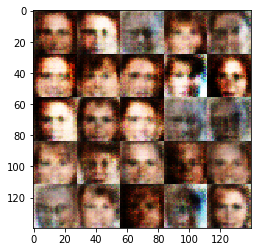

Epoch 811/1... Discriminator Loss: 1.4495... Generator Loss: 0.7901
Epoch 821/1... Discriminator Loss: 1.4732... Generator Loss: 0.7584
Epoch 831/1... Discriminator Loss: 1.4483... Generator Loss: 0.6452
Epoch 841/1... Discriminator Loss: 1.4510... Generator Loss: 0.7055
Epoch 851/1... Discriminator Loss: 1.4836... Generator Loss: 0.6067
Epoch 861/1... Discriminator Loss: 1.4298... Generator Loss: 0.6481
Epoch 871/1... Discriminator Loss: 1.5393... Generator Loss: 0.6186
Epoch 881/1... Discriminator Loss: 1.4964... Generator Loss: 0.5494
Epoch 891/1... Discriminator Loss: 1.4771... Generator Loss: 0.7800
Epoch 901/1... Discriminator Loss: 1.5131... Generator Loss: 1.0518


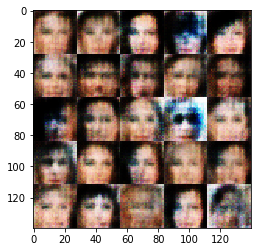

Epoch 911/1... Discriminator Loss: 1.4368... Generator Loss: 0.7696
Epoch 921/1... Discriminator Loss: 1.4256... Generator Loss: 0.7092
Epoch 931/1... Discriminator Loss: 1.4462... Generator Loss: 0.7181
Epoch 941/1... Discriminator Loss: 1.4887... Generator Loss: 0.5384
Epoch 951/1... Discriminator Loss: 1.4930... Generator Loss: 0.6835
Epoch 961/1... Discriminator Loss: 1.4497... Generator Loss: 0.6644
Epoch 971/1... Discriminator Loss: 1.4452... Generator Loss: 0.6858
Epoch 981/1... Discriminator Loss: 1.4322... Generator Loss: 0.7382
Epoch 991/1... Discriminator Loss: 1.4600... Generator Loss: 0.6643
Epoch 1001/1... Discriminator Loss: 1.4773... Generator Loss: 0.5928


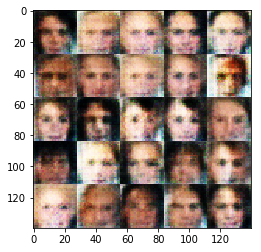

Epoch 1011/1... Discriminator Loss: 1.4204... Generator Loss: 0.7139
Epoch 1021/1... Discriminator Loss: 1.4611... Generator Loss: 0.6603
Epoch 1031/1... Discriminator Loss: 1.4597... Generator Loss: 0.7061
Epoch 1041/1... Discriminator Loss: 1.4804... Generator Loss: 0.6799
Epoch 1051/1... Discriminator Loss: 1.4568... Generator Loss: 0.7157
Epoch 1061/1... Discriminator Loss: 1.4198... Generator Loss: 0.7374
Epoch 1071/1... Discriminator Loss: 1.4605... Generator Loss: 0.6687
Epoch 1081/1... Discriminator Loss: 1.4595... Generator Loss: 0.7231
Epoch 1091/1... Discriminator Loss: 1.4471... Generator Loss: 0.7231
Epoch 1101/1... Discriminator Loss: 1.4752... Generator Loss: 0.6173


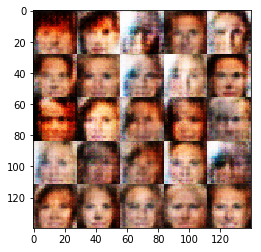

Epoch 1111/1... Discriminator Loss: 1.5055... Generator Loss: 0.6262
Epoch 1121/1... Discriminator Loss: 1.4271... Generator Loss: 0.6925
Epoch 1131/1... Discriminator Loss: 1.4824... Generator Loss: 0.6482
Epoch 1141/1... Discriminator Loss: 1.4678... Generator Loss: 0.6077
Epoch 1151/1... Discriminator Loss: 1.4166... Generator Loss: 0.6859
Epoch 1161/1... Discriminator Loss: 1.4077... Generator Loss: 0.8461
Epoch 1171/1... Discriminator Loss: 1.4700... Generator Loss: 0.5747
Epoch 1181/1... Discriminator Loss: 1.4437... Generator Loss: 0.7270
Epoch 1191/1... Discriminator Loss: 1.4979... Generator Loss: 0.5891
Epoch 1201/1... Discriminator Loss: 1.4278... Generator Loss: 0.7616


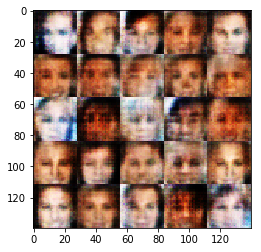

Epoch 1211/1... Discriminator Loss: 1.4390... Generator Loss: 0.6980
Epoch 1221/1... Discriminator Loss: 1.5020... Generator Loss: 0.8439
Epoch 1231/1... Discriminator Loss: 1.4585... Generator Loss: 0.6078
Epoch 1241/1... Discriminator Loss: 1.4521... Generator Loss: 0.6743
Epoch 1251/1... Discriminator Loss: 1.4127... Generator Loss: 0.7710
Epoch 1261/1... Discriminator Loss: 1.4252... Generator Loss: 0.6955
Epoch 1271/1... Discriminator Loss: 1.4238... Generator Loss: 0.6930
Epoch 1281/1... Discriminator Loss: 1.4367... Generator Loss: 0.7915
Epoch 1291/1... Discriminator Loss: 1.5270... Generator Loss: 0.6783
Epoch 1301/1... Discriminator Loss: 1.5022... Generator Loss: 0.5153


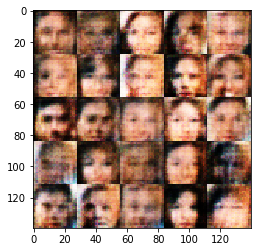

Epoch 1311/1... Discriminator Loss: 1.4134... Generator Loss: 0.8177
Epoch 1321/1... Discriminator Loss: 1.4467... Generator Loss: 0.9188
Epoch 1331/1... Discriminator Loss: 1.4517... Generator Loss: 0.6622
Epoch 1341/1... Discriminator Loss: 1.4846... Generator Loss: 0.5985
Epoch 1351/1... Discriminator Loss: 1.4603... Generator Loss: 0.6735
Epoch 1361/1... Discriminator Loss: 1.4478... Generator Loss: 0.6720
Epoch 1371/1... Discriminator Loss: 1.4807... Generator Loss: 0.7810
Epoch 1381/1... Discriminator Loss: 1.4394... Generator Loss: 0.7208
Epoch 1391/1... Discriminator Loss: 1.4266... Generator Loss: 0.6883
Epoch 1401/1... Discriminator Loss: 1.4176... Generator Loss: 0.7287


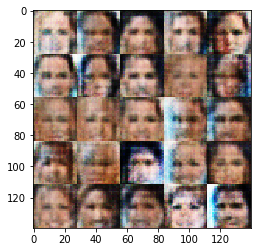

Epoch 1411/1... Discriminator Loss: 1.4853... Generator Loss: 0.8288
Epoch 1421/1... Discriminator Loss: 1.4233... Generator Loss: 0.8430
Epoch 1431/1... Discriminator Loss: 1.4323... Generator Loss: 0.7853
Epoch 1441/1... Discriminator Loss: 1.4600... Generator Loss: 0.7441
Epoch 1451/1... Discriminator Loss: 1.4518... Generator Loss: 0.6101
Epoch 1461/1... Discriminator Loss: 1.4226... Generator Loss: 0.7526
Epoch 1471/1... Discriminator Loss: 1.4141... Generator Loss: 0.7073
Epoch 1481/1... Discriminator Loss: 1.4345... Generator Loss: 0.7297
Epoch 1491/1... Discriminator Loss: 1.4381... Generator Loss: 0.7107
Epoch 1501/1... Discriminator Loss: 1.4510... Generator Loss: 0.6223


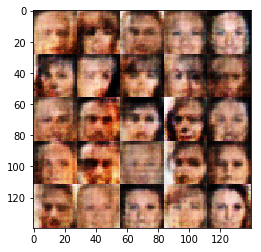

Epoch 1511/1... Discriminator Loss: 1.4536... Generator Loss: 0.7496
Epoch 1521/1... Discriminator Loss: 1.3894... Generator Loss: 0.7944
Epoch 1531/1... Discriminator Loss: 1.4179... Generator Loss: 0.8063
Epoch 1541/1... Discriminator Loss: 1.4131... Generator Loss: 0.7307
Epoch 1551/1... Discriminator Loss: 1.4600... Generator Loss: 0.6526
Epoch 1561/1... Discriminator Loss: 1.4481... Generator Loss: 0.6888
Epoch 1571/1... Discriminator Loss: 1.4368... Generator Loss: 0.7359
Epoch 1581/1... Discriminator Loss: 1.4379... Generator Loss: 0.6533
Epoch 1591/1... Discriminator Loss: 1.4399... Generator Loss: 0.7324
Epoch 1601/1... Discriminator Loss: 1.4467... Generator Loss: 0.8060


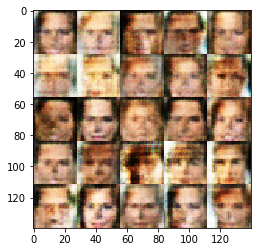

Epoch 1611/1... Discriminator Loss: 1.4301... Generator Loss: 0.8048
Epoch 1621/1... Discriminator Loss: 1.4769... Generator Loss: 0.5739
Epoch 1631/1... Discriminator Loss: 1.4183... Generator Loss: 0.7454
Epoch 1641/1... Discriminator Loss: 1.4309... Generator Loss: 0.6840
Epoch 1651/1... Discriminator Loss: 1.4235... Generator Loss: 0.7262
Epoch 1661/1... Discriminator Loss: 1.4469... Generator Loss: 0.9025
Epoch 1671/1... Discriminator Loss: 1.4427... Generator Loss: 0.9122
Epoch 1681/1... Discriminator Loss: 1.4478... Generator Loss: 0.8917
Epoch 1691/1... Discriminator Loss: 1.4645... Generator Loss: 0.8771
Epoch 1701/1... Discriminator Loss: 1.4404... Generator Loss: 0.7295


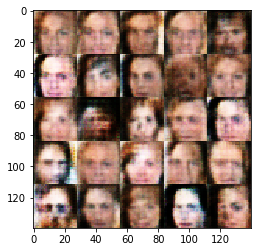

Epoch 1711/1... Discriminator Loss: 1.4675... Generator Loss: 0.8768
Epoch 1721/1... Discriminator Loss: 1.4599... Generator Loss: 0.6602
Epoch 1731/1... Discriminator Loss: 1.4449... Generator Loss: 0.6169
Epoch 1741/1... Discriminator Loss: 1.4391... Generator Loss: 0.6936
Epoch 1751/1... Discriminator Loss: 1.4230... Generator Loss: 0.7079
Epoch 1761/1... Discriminator Loss: 1.4550... Generator Loss: 0.6019
Epoch 1771/1... Discriminator Loss: 1.4284... Generator Loss: 0.6755
Epoch 1781/1... Discriminator Loss: 1.4426... Generator Loss: 0.8466
Epoch 1791/1... Discriminator Loss: 1.4237... Generator Loss: 0.8413
Epoch 1801/1... Discriminator Loss: 1.4130... Generator Loss: 0.6851


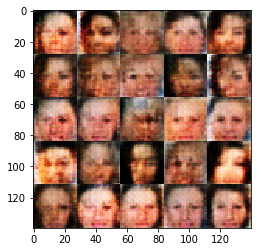

Epoch 1811/1... Discriminator Loss: 1.4517... Generator Loss: 0.8437
Epoch 1821/1... Discriminator Loss: 1.4631... Generator Loss: 0.7188
Epoch 1831/1... Discriminator Loss: 1.4333... Generator Loss: 0.8071
Epoch 1841/1... Discriminator Loss: 1.4421... Generator Loss: 0.7601
Epoch 1851/1... Discriminator Loss: 1.4470... Generator Loss: 0.8045
Epoch 1861/1... Discriminator Loss: 1.4469... Generator Loss: 0.9049
Epoch 1871/1... Discriminator Loss: 1.4261... Generator Loss: 0.8373
Epoch 1881/1... Discriminator Loss: 1.4094... Generator Loss: 0.6988
Epoch 1891/1... Discriminator Loss: 1.4318... Generator Loss: 0.8408
Epoch 1901/1... Discriminator Loss: 1.4485... Generator Loss: 0.6898


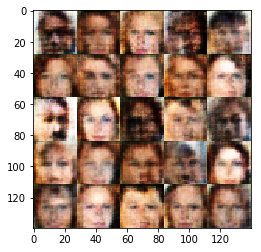

Epoch 1911/1... Discriminator Loss: 1.4274... Generator Loss: 0.8009
Epoch 1921/1... Discriminator Loss: 1.4304... Generator Loss: 0.6430
Epoch 1931/1... Discriminator Loss: 1.4396... Generator Loss: 0.7829
Epoch 1941/1... Discriminator Loss: 1.4333... Generator Loss: 0.7593
Epoch 1951/1... Discriminator Loss: 1.4149... Generator Loss: 0.7716
Epoch 1961/1... Discriminator Loss: 1.4382... Generator Loss: 0.6711
Epoch 1971/1... Discriminator Loss: 1.4125... Generator Loss: 0.7332
Epoch 1981/1... Discriminator Loss: 1.4433... Generator Loss: 0.7342
Epoch 1991/1... Discriminator Loss: 1.4429... Generator Loss: 0.6946
Epoch 2001/1... Discriminator Loss: 1.4688... Generator Loss: 0.5686


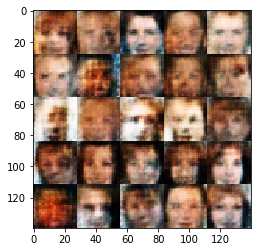

Epoch 2011/1... Discriminator Loss: 1.4089... Generator Loss: 0.7198
Epoch 2021/1... Discriminator Loss: 1.4405... Generator Loss: 0.8165
Epoch 2031/1... Discriminator Loss: 1.4268... Generator Loss: 0.6436
Epoch 2041/1... Discriminator Loss: 1.4306... Generator Loss: 0.6533
Epoch 2051/1... Discriminator Loss: 1.3910... Generator Loss: 0.7786
Epoch 2061/1... Discriminator Loss: 1.4229... Generator Loss: 0.7993
Epoch 2071/1... Discriminator Loss: 1.4344... Generator Loss: 0.6963
Epoch 2081/1... Discriminator Loss: 1.4362... Generator Loss: 0.8698
Epoch 2091/1... Discriminator Loss: 1.4554... Generator Loss: 0.5484
Epoch 2101/1... Discriminator Loss: 1.4281... Generator Loss: 0.7755


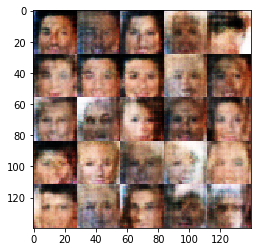

Epoch 2111/1... Discriminator Loss: 1.4213... Generator Loss: 0.8779
Epoch 2121/1... Discriminator Loss: 1.4304... Generator Loss: 0.7350
Epoch 2131/1... Discriminator Loss: 1.4066... Generator Loss: 0.7952
Epoch 2141/1... Discriminator Loss: 1.4304... Generator Loss: 0.7673
Epoch 2151/1... Discriminator Loss: 1.4354... Generator Loss: 0.6851
Epoch 2161/1... Discriminator Loss: 1.4328... Generator Loss: 0.7400
Epoch 2171/1... Discriminator Loss: 1.4194... Generator Loss: 0.8381
Epoch 2181/1... Discriminator Loss: 1.4223... Generator Loss: 0.7903
Epoch 2191/1... Discriminator Loss: 1.4141... Generator Loss: 0.7148
Epoch 2201/1... Discriminator Loss: 1.4120... Generator Loss: 0.7157


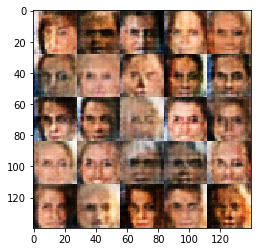

Epoch 2211/1... Discriminator Loss: 1.4547... Generator Loss: 0.6320
Epoch 2221/1... Discriminator Loss: 1.4292... Generator Loss: 0.8454
Epoch 2231/1... Discriminator Loss: 1.3972... Generator Loss: 0.8523
Epoch 2241/1... Discriminator Loss: 1.4208... Generator Loss: 0.6894
Epoch 2251/1... Discriminator Loss: 1.4196... Generator Loss: 0.6584
Epoch 2261/1... Discriminator Loss: 1.4272... Generator Loss: 0.6316
Epoch 2271/1... Discriminator Loss: 1.4654... Generator Loss: 0.5925
Epoch 2281/1... Discriminator Loss: 1.4173... Generator Loss: 0.7035
Epoch 2291/1... Discriminator Loss: 1.4221... Generator Loss: 0.7288
Epoch 2301/1... Discriminator Loss: 1.4114... Generator Loss: 0.8132


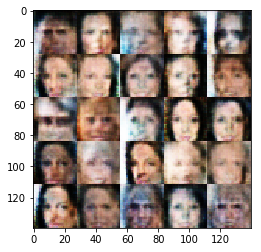

Epoch 2311/1... Discriminator Loss: 1.4182... Generator Loss: 0.7123
Epoch 2321/1... Discriminator Loss: 1.4240... Generator Loss: 0.6769
Epoch 2331/1... Discriminator Loss: 1.4074... Generator Loss: 0.7866
Epoch 2341/1... Discriminator Loss: 1.4187... Generator Loss: 0.7568
Epoch 2351/1... Discriminator Loss: 1.4228... Generator Loss: 0.6801
Epoch 2361/1... Discriminator Loss: 1.4672... Generator Loss: 0.5552
Epoch 2371/1... Discriminator Loss: 1.4237... Generator Loss: 0.7396
Epoch 2381/1... Discriminator Loss: 1.4111... Generator Loss: 0.7071
Epoch 2391/1... Discriminator Loss: 1.4216... Generator Loss: 0.7332
Epoch 2401/1... Discriminator Loss: 1.4360... Generator Loss: 0.6516


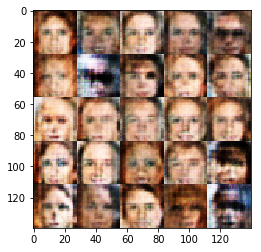

Epoch 2411/1... Discriminator Loss: 1.4011... Generator Loss: 0.7586
Epoch 2421/1... Discriminator Loss: 1.3964... Generator Loss: 0.7485
Epoch 2431/1... Discriminator Loss: 1.4219... Generator Loss: 0.9135
Epoch 2441/1... Discriminator Loss: 1.4426... Generator Loss: 0.8733
Epoch 2451/1... Discriminator Loss: 1.4026... Generator Loss: 0.8653
Epoch 2461/1... Discriminator Loss: 1.4406... Generator Loss: 0.9677
Epoch 2471/1... Discriminator Loss: 1.4414... Generator Loss: 0.7702
Epoch 2481/1... Discriminator Loss: 1.4110... Generator Loss: 0.7053
Epoch 2491/1... Discriminator Loss: 1.4247... Generator Loss: 0.7680
Epoch 2501/1... Discriminator Loss: 1.4002... Generator Loss: 0.7552


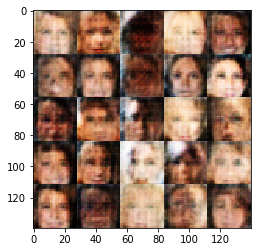

Epoch 2511/1... Discriminator Loss: 1.4400... Generator Loss: 0.8355
Epoch 2521/1... Discriminator Loss: 1.3970... Generator Loss: 0.7822
Epoch 2531/1... Discriminator Loss: 1.4111... Generator Loss: 0.7764
Epoch 2541/1... Discriminator Loss: 1.4122... Generator Loss: 0.7251
Epoch 2551/1... Discriminator Loss: 1.4482... Generator Loss: 0.8547
Epoch 2561/1... Discriminator Loss: 1.4273... Generator Loss: 0.8369
Epoch 2571/1... Discriminator Loss: 1.4277... Generator Loss: 0.7953
Epoch 2581/1... Discriminator Loss: 1.4043... Generator Loss: 0.7539
Epoch 2591/1... Discriminator Loss: 1.4075... Generator Loss: 0.8327
Epoch 2601/1... Discriminator Loss: 1.4129... Generator Loss: 0.7295


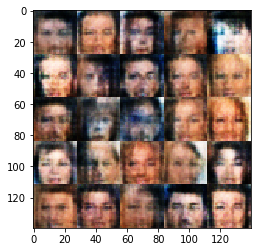

Epoch 2611/1... Discriminator Loss: 1.4026... Generator Loss: 0.7400
Epoch 2621/1... Discriminator Loss: 1.4586... Generator Loss: 0.7980
Epoch 2631/1... Discriminator Loss: 1.4277... Generator Loss: 0.8215
Epoch 2641/1... Discriminator Loss: 1.4447... Generator Loss: 0.6385
Epoch 2651/1... Discriminator Loss: 1.3975... Generator Loss: 0.7667
Epoch 2661/1... Discriminator Loss: 1.4060... Generator Loss: 0.8322
Epoch 2671/1... Discriminator Loss: 1.4268... Generator Loss: 0.7439
Epoch 2681/1... Discriminator Loss: 1.4181... Generator Loss: 0.6938
Epoch 2691/1... Discriminator Loss: 1.3982... Generator Loss: 0.7870
Epoch 2701/1... Discriminator Loss: 1.4404... Generator Loss: 0.6262


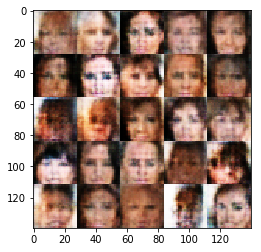

Epoch 2711/1... Discriminator Loss: 1.4627... Generator Loss: 0.5626
Epoch 2721/1... Discriminator Loss: 1.4304... Generator Loss: 0.6388
Epoch 2731/1... Discriminator Loss: 1.4110... Generator Loss: 0.7966
Epoch 2741/1... Discriminator Loss: 1.4130... Generator Loss: 0.8956
Epoch 2751/1... Discriminator Loss: 1.3916... Generator Loss: 0.7869
Epoch 2761/1... Discriminator Loss: 1.4227... Generator Loss: 0.7030
Epoch 2771/1... Discriminator Loss: 1.4288... Generator Loss: 0.7214
Epoch 2781/1... Discriminator Loss: 1.3983... Generator Loss: 0.7115
Epoch 2791/1... Discriminator Loss: 1.4567... Generator Loss: 0.5844
Epoch 2801/1... Discriminator Loss: 1.4368... Generator Loss: 0.6621


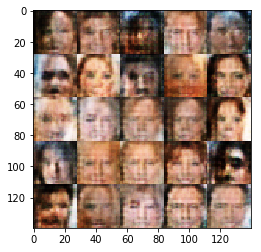

Epoch 2811/1... Discriminator Loss: 1.4192... Generator Loss: 0.8843
Epoch 2821/1... Discriminator Loss: 1.4161... Generator Loss: 0.7486
Epoch 2831/1... Discriminator Loss: 1.3944... Generator Loss: 0.7946
Epoch 2841/1... Discriminator Loss: 1.4040... Generator Loss: 0.6969
Epoch 2851/1... Discriminator Loss: 1.4063... Generator Loss: 0.7772
Epoch 2861/1... Discriminator Loss: 1.4188... Generator Loss: 0.9170
Epoch 2871/1... Discriminator Loss: 1.4099... Generator Loss: 0.8231
Epoch 2881/1... Discriminator Loss: 1.4285... Generator Loss: 0.6491
Epoch 2891/1... Discriminator Loss: 1.4140... Generator Loss: 0.7221
Epoch 2901/1... Discriminator Loss: 1.4277... Generator Loss: 0.6326


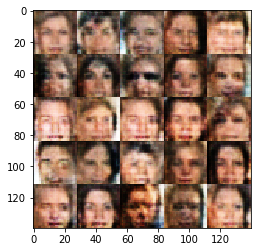

Epoch 2911/1... Discriminator Loss: 1.4317... Generator Loss: 0.6357
Epoch 2921/1... Discriminator Loss: 1.4965... Generator Loss: 0.5382
Epoch 2931/1... Discriminator Loss: 1.4267... Generator Loss: 0.8467
Epoch 2941/1... Discriminator Loss: 1.4339... Generator Loss: 0.9619
Epoch 2951/1... Discriminator Loss: 1.4093... Generator Loss: 0.8084
Epoch 2961/1... Discriminator Loss: 1.4226... Generator Loss: 0.6708
Epoch 2971/1... Discriminator Loss: 1.4003... Generator Loss: 0.7475
Epoch 2981/1... Discriminator Loss: 1.4254... Generator Loss: 0.6881
Epoch 2991/1... Discriminator Loss: 1.4150... Generator Loss: 0.8848
Epoch 3001/1... Discriminator Loss: 1.4155... Generator Loss: 0.6700


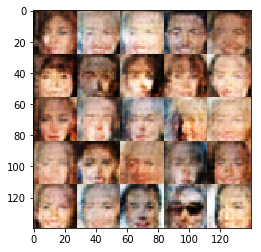

Epoch 3011/1... Discriminator Loss: 1.4104... Generator Loss: 0.7247
Epoch 3021/1... Discriminator Loss: 1.4073... Generator Loss: 0.7319
Epoch 3031/1... Discriminator Loss: 1.3978... Generator Loss: 0.7518
Epoch 3041/1... Discriminator Loss: 1.4283... Generator Loss: 0.6309
Epoch 3051/1... Discriminator Loss: 1.4225... Generator Loss: 0.6517
Epoch 3061/1... Discriminator Loss: 1.4147... Generator Loss: 0.6952
Epoch 3071/1... Discriminator Loss: 1.4056... Generator Loss: 0.7313
Epoch 3081/1... Discriminator Loss: 1.4244... Generator Loss: 0.6985
Epoch 3091/1... Discriminator Loss: 1.4015... Generator Loss: 0.8092
Epoch 3101/1... Discriminator Loss: 1.4124... Generator Loss: 0.7942


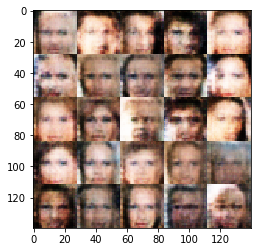

Epoch 3111/1... Discriminator Loss: 1.4017... Generator Loss: 0.7331
Epoch 3121/1... Discriminator Loss: 1.4080... Generator Loss: 0.7551
Epoch 3131/1... Discriminator Loss: 1.4189... Generator Loss: 0.7832
Epoch 3141/1... Discriminator Loss: 1.4160... Generator Loss: 0.8592
Epoch 3151/1... Discriminator Loss: 1.4241... Generator Loss: 0.9159
Epoch 3161/1... Discriminator Loss: 1.4137... Generator Loss: 0.8992
Epoch 3171/1... Discriminator Loss: 1.4363... Generator Loss: 0.9394
Epoch 3181/1... Discriminator Loss: 1.4253... Generator Loss: 0.8845
Epoch 3191/1... Discriminator Loss: 1.4086... Generator Loss: 0.8825
Epoch 3201/1... Discriminator Loss: 1.4501... Generator Loss: 0.5799


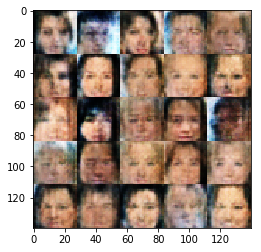

Epoch 3211/1... Discriminator Loss: 1.4214... Generator Loss: 0.8452
Epoch 3221/1... Discriminator Loss: 1.4037... Generator Loss: 0.8043
Epoch 3231/1... Discriminator Loss: 1.4128... Generator Loss: 0.7089
Epoch 3241/1... Discriminator Loss: 1.4059... Generator Loss: 0.7694
Epoch 3251/1... Discriminator Loss: 1.4072... Generator Loss: 0.8240
Epoch 3261/1... Discriminator Loss: 1.4032... Generator Loss: 0.7276
Epoch 3271/1... Discriminator Loss: 1.4339... Generator Loss: 0.6205
Epoch 3281/1... Discriminator Loss: 1.4395... Generator Loss: 0.6433
Epoch 3291/1... Discriminator Loss: 1.4569... Generator Loss: 0.5842
Epoch 3301/1... Discriminator Loss: 1.4081... Generator Loss: 0.7434


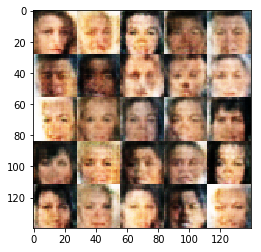

Epoch 3311/1... Discriminator Loss: 1.4114... Generator Loss: 0.7087
Epoch 3321/1... Discriminator Loss: 1.4179... Generator Loss: 0.7010
Epoch 3331/1... Discriminator Loss: 1.4158... Generator Loss: 0.7809
Epoch 3341/1... Discriminator Loss: 1.4035... Generator Loss: 0.7502
Epoch 3351/1... Discriminator Loss: 1.4076... Generator Loss: 0.8273
Epoch 3361/1... Discriminator Loss: 1.4405... Generator Loss: 0.5875
Epoch 3371/1... Discriminator Loss: 1.4107... Generator Loss: 0.7058
Epoch 3381/1... Discriminator Loss: 1.4160... Generator Loss: 0.6772
Epoch 3391/1... Discriminator Loss: 1.4316... Generator Loss: 0.6919
Epoch 3401/1... Discriminator Loss: 1.4172... Generator Loss: 0.7871


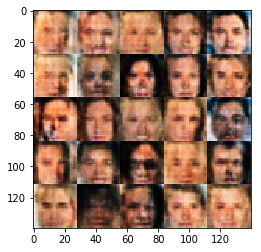

Epoch 3411/1... Discriminator Loss: 1.4106... Generator Loss: 0.7984
Epoch 3421/1... Discriminator Loss: 1.4143... Generator Loss: 0.7247
Epoch 3431/1... Discriminator Loss: 1.4060... Generator Loss: 0.6652
Epoch 3441/1... Discriminator Loss: 1.4318... Generator Loss: 0.6342
Epoch 3451/1... Discriminator Loss: 1.3770... Generator Loss: 0.8056
Epoch 3461/1... Discriminator Loss: 1.4241... Generator Loss: 0.8060
Epoch 3471/1... Discriminator Loss: 1.4241... Generator Loss: 0.9392
Epoch 3481/1... Discriminator Loss: 1.4034... Generator Loss: 0.7328
Epoch 3491/1... Discriminator Loss: 1.4128... Generator Loss: 0.8012
Epoch 3501/1... Discriminator Loss: 1.4072... Generator Loss: 0.7270


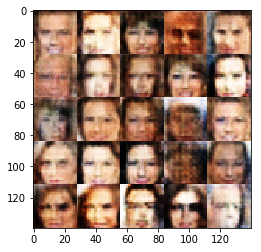

Epoch 3511/1... Discriminator Loss: 1.4131... Generator Loss: 0.7203
Epoch 3521/1... Discriminator Loss: 1.4201... Generator Loss: 0.6771
Epoch 3531/1... Discriminator Loss: 1.4328... Generator Loss: 0.7012
Epoch 3541/1... Discriminator Loss: 1.4169... Generator Loss: 0.6761
Epoch 3551/1... Discriminator Loss: 1.4003... Generator Loss: 0.7771
Epoch 3561/1... Discriminator Loss: 1.4021... Generator Loss: 0.7551
Epoch 3571/1... Discriminator Loss: 1.4255... Generator Loss: 0.7729
Epoch 3581/1... Discriminator Loss: 1.4167... Generator Loss: 0.9686
Epoch 3591/1... Discriminator Loss: 1.4197... Generator Loss: 0.8292
Epoch 3601/1... Discriminator Loss: 1.4372... Generator Loss: 0.6784


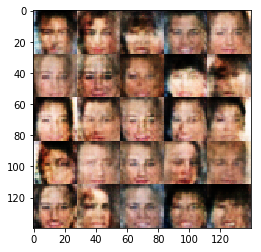

Epoch 3611/1... Discriminator Loss: 1.4444... Generator Loss: 0.5942
Epoch 3621/1... Discriminator Loss: 1.4155... Generator Loss: 0.6722
Epoch 3631/1... Discriminator Loss: 1.4000... Generator Loss: 0.7324
Epoch 3641/1... Discriminator Loss: 1.4054... Generator Loss: 0.8249
Epoch 3651/1... Discriminator Loss: 1.4053... Generator Loss: 0.8534
Epoch 3661/1... Discriminator Loss: 1.4055... Generator Loss: 0.7168
Epoch 3671/1... Discriminator Loss: 1.4251... Generator Loss: 0.6563
Epoch 3681/1... Discriminator Loss: 1.4019... Generator Loss: 0.8326
Epoch 3691/1... Discriminator Loss: 1.4006... Generator Loss: 0.8865
Epoch 3701/1... Discriminator Loss: 1.4512... Generator Loss: 0.8666


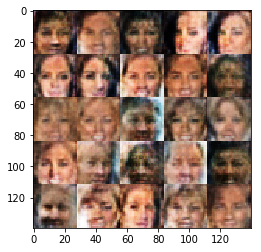

Epoch 3711/1... Discriminator Loss: 1.4073... Generator Loss: 0.6421
Epoch 3721/1... Discriminator Loss: 1.4253... Generator Loss: 0.6344
Epoch 3731/1... Discriminator Loss: 1.4002... Generator Loss: 0.7275
Epoch 3741/1... Discriminator Loss: 1.4122... Generator Loss: 0.7261
Epoch 3751/1... Discriminator Loss: 1.3924... Generator Loss: 0.7952
Epoch 3761/1... Discriminator Loss: 1.4066... Generator Loss: 0.8070
Epoch 3771/1... Discriminator Loss: 1.3948... Generator Loss: 0.6968
Epoch 3781/1... Discriminator Loss: 1.3969... Generator Loss: 0.7504
Epoch 3791/1... Discriminator Loss: 1.4198... Generator Loss: 0.6537
Epoch 3801/1... Discriminator Loss: 1.4185... Generator Loss: 0.7596


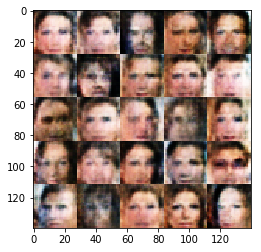

Epoch 3811/1... Discriminator Loss: 1.4321... Generator Loss: 0.6204
Epoch 3821/1... Discriminator Loss: 1.4106... Generator Loss: 0.7038
Epoch 3831/1... Discriminator Loss: 1.3929... Generator Loss: 0.7508
Epoch 3841/1... Discriminator Loss: 1.4138... Generator Loss: 0.8264
Epoch 3851/1... Discriminator Loss: 1.3926... Generator Loss: 0.7526
Epoch 3861/1... Discriminator Loss: 1.3960... Generator Loss: 0.7875
Epoch 3871/1... Discriminator Loss: 1.4221... Generator Loss: 0.6531
Epoch 3881/1... Discriminator Loss: 1.4114... Generator Loss: 0.7185
Epoch 3891/1... Discriminator Loss: 1.4028... Generator Loss: 0.7821
Epoch 3901/1... Discriminator Loss: 1.4361... Generator Loss: 0.6228


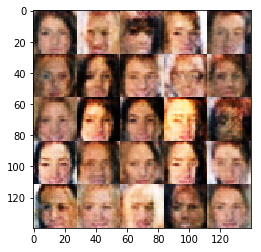

Epoch 3911/1... Discriminator Loss: 1.3959... Generator Loss: 0.7780
Epoch 3921/1... Discriminator Loss: 1.4158... Generator Loss: 0.9004
Epoch 3931/1... Discriminator Loss: 1.4006... Generator Loss: 0.8343
Epoch 3941/1... Discriminator Loss: 1.3984... Generator Loss: 0.8592
Epoch 3951/1... Discriminator Loss: 1.3996... Generator Loss: 0.7596
Epoch 3961/1... Discriminator Loss: 1.4080... Generator Loss: 0.7298
Epoch 3971/1... Discriminator Loss: 1.4119... Generator Loss: 0.6719
Epoch 3981/1... Discriminator Loss: 1.3995... Generator Loss: 0.7291
Epoch 3991/1... Discriminator Loss: 1.3952... Generator Loss: 0.6936
Epoch 4001/1... Discriminator Loss: 1.4168... Generator Loss: 0.8063


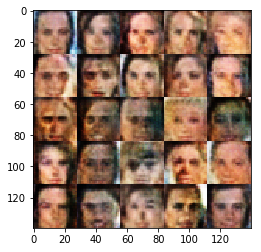

Epoch 4011/1... Discriminator Loss: 1.4236... Generator Loss: 0.9140
Epoch 4021/1... Discriminator Loss: 1.4157... Generator Loss: 0.9118
Epoch 4031/1... Discriminator Loss: 1.4056... Generator Loss: 0.8016
Epoch 4041/1... Discriminator Loss: 1.4071... Generator Loss: 0.7143
Epoch 4051/1... Discriminator Loss: 1.4024... Generator Loss: 0.7468
Epoch 4061/1... Discriminator Loss: 1.4216... Generator Loss: 0.6220
Epoch 4071/1... Discriminator Loss: 1.3934... Generator Loss: 0.7992
Epoch 4081/1... Discriminator Loss: 1.4019... Generator Loss: 0.8037
Epoch 4091/1... Discriminator Loss: 1.4039... Generator Loss: 0.8303
Epoch 4101/1... Discriminator Loss: 1.4313... Generator Loss: 0.6611


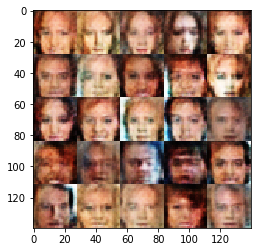

Epoch 4111/1... Discriminator Loss: 1.4077... Generator Loss: 0.8069
Epoch 4121/1... Discriminator Loss: 1.4061... Generator Loss: 0.8717
Epoch 4131/1... Discriminator Loss: 1.4334... Generator Loss: 0.9499
Epoch 4141/1... Discriminator Loss: 1.3966... Generator Loss: 0.7955
Epoch 4151/1... Discriminator Loss: 1.3952... Generator Loss: 0.6915
Epoch 4161/1... Discriminator Loss: 1.4177... Generator Loss: 0.9004
Epoch 4171/1... Discriminator Loss: 1.4346... Generator Loss: 0.9416
Epoch 4181/1... Discriminator Loss: 1.4182... Generator Loss: 0.8961
Epoch 4191/1... Discriminator Loss: 1.4059... Generator Loss: 0.8342
Epoch 4201/1... Discriminator Loss: 1.4373... Generator Loss: 0.9868


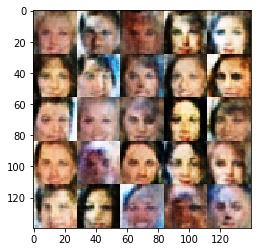

Epoch 4211/1... Discriminator Loss: 1.4025... Generator Loss: 0.7864
Epoch 4221/1... Discriminator Loss: 1.4222... Generator Loss: 0.6893
Epoch 4231/1... Discriminator Loss: 1.4164... Generator Loss: 0.7683
Epoch 4241/1... Discriminator Loss: 1.4108... Generator Loss: 0.7808
Epoch 4251/1... Discriminator Loss: 1.3959... Generator Loss: 0.7437
Epoch 4261/1... Discriminator Loss: 1.4185... Generator Loss: 0.6524
Epoch 4271/1... Discriminator Loss: 1.3976... Generator Loss: 0.7068
Epoch 4281/1... Discriminator Loss: 1.4131... Generator Loss: 0.7107
Epoch 4291/1... Discriminator Loss: 1.4333... Generator Loss: 0.6476
Epoch 4301/1... Discriminator Loss: 1.4118... Generator Loss: 0.6668


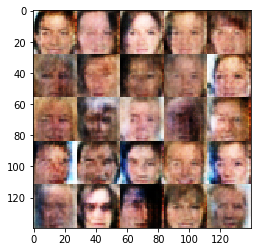

Epoch 4311/1... Discriminator Loss: 1.4042... Generator Loss: 0.7019
Epoch 4321/1... Discriminator Loss: 1.4020... Generator Loss: 0.7365
Epoch 4331/1... Discriminator Loss: 1.4025... Generator Loss: 0.7233
Epoch 4341/1... Discriminator Loss: 1.4143... Generator Loss: 0.6768
Epoch 4351/1... Discriminator Loss: 1.4288... Generator Loss: 0.6111
Epoch 4361/1... Discriminator Loss: 1.3984... Generator Loss: 0.7095
Epoch 4371/1... Discriminator Loss: 1.3978... Generator Loss: 0.6870
Epoch 4381/1... Discriminator Loss: 1.4030... Generator Loss: 0.9020
Epoch 4391/1... Discriminator Loss: 1.4424... Generator Loss: 0.9954
Epoch 4401/1... Discriminator Loss: 1.4070... Generator Loss: 0.8446


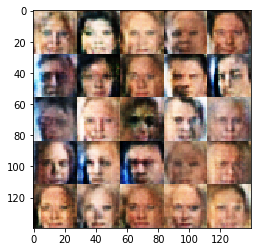

Epoch 4411/1... Discriminator Loss: 1.4419... Generator Loss: 0.7522
Epoch 4421/1... Discriminator Loss: 1.4099... Generator Loss: 0.8440
Epoch 4431/1... Discriminator Loss: 1.4288... Generator Loss: 0.8121
Epoch 4441/1... Discriminator Loss: 1.3928... Generator Loss: 0.7016
Epoch 4451/1... Discriminator Loss: 1.4058... Generator Loss: 0.8255
Epoch 4461/1... Discriminator Loss: 1.3971... Generator Loss: 0.7059
Epoch 4471/1... Discriminator Loss: 1.4256... Generator Loss: 0.6240
Epoch 4481/1... Discriminator Loss: 1.4179... Generator Loss: 0.6510
Epoch 4491/1... Discriminator Loss: 1.3986... Generator Loss: 0.7229
Epoch 4501/1... Discriminator Loss: 1.3926... Generator Loss: 0.7263


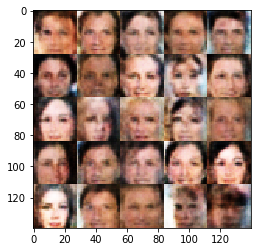

Epoch 4511/1... Discriminator Loss: 1.3858... Generator Loss: 0.8461
Epoch 4521/1... Discriminator Loss: 1.3943... Generator Loss: 0.7243
Epoch 4531/1... Discriminator Loss: 1.4073... Generator Loss: 0.6694
Epoch 4541/1... Discriminator Loss: 1.4422... Generator Loss: 0.5936
Epoch 4551/1... Discriminator Loss: 1.4082... Generator Loss: 0.7223
Epoch 4561/1... Discriminator Loss: 1.4147... Generator Loss: 0.6441
Epoch 4571/1... Discriminator Loss: 1.4146... Generator Loss: 0.6788
Epoch 4581/1... Discriminator Loss: 1.4096... Generator Loss: 0.8495
Epoch 4591/1... Discriminator Loss: 1.4116... Generator Loss: 0.7732
Epoch 4601/1... Discriminator Loss: 1.4077... Generator Loss: 0.8044


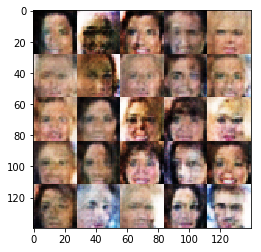

Epoch 4611/1... Discriminator Loss: 1.3998... Generator Loss: 0.7720
Epoch 4621/1... Discriminator Loss: 1.4045... Generator Loss: 0.6961
Epoch 4631/1... Discriminator Loss: 1.4100... Generator Loss: 0.6859
Epoch 4641/1... Discriminator Loss: 1.4025... Generator Loss: 0.7700
Epoch 4651/1... Discriminator Loss: 1.4040... Generator Loss: 0.8956
Epoch 4661/1... Discriminator Loss: 1.3882... Generator Loss: 0.7885
Epoch 4671/1... Discriminator Loss: 1.3916... Generator Loss: 0.7422
Epoch 4681/1... Discriminator Loss: 1.4012... Generator Loss: 0.7042
Epoch 4691/1... Discriminator Loss: 1.4053... Generator Loss: 0.7095
Epoch 4701/1... Discriminator Loss: 1.4150... Generator Loss: 0.9418


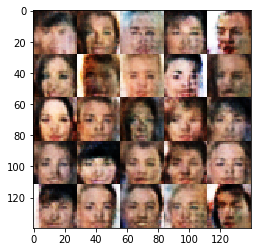

Epoch 4711/1... Discriminator Loss: 1.4142... Generator Loss: 0.9306
Epoch 4721/1... Discriminator Loss: 1.4154... Generator Loss: 0.7835
Epoch 4731/1... Discriminator Loss: 1.3917... Generator Loss: 0.7727
Epoch 4741/1... Discriminator Loss: 1.3947... Generator Loss: 0.7703
Epoch 4751/1... Discriminator Loss: 1.4116... Generator Loss: 0.7028
Epoch 4761/1... Discriminator Loss: 1.3869... Generator Loss: 0.8659
Epoch 4771/1... Discriminator Loss: 1.4067... Generator Loss: 0.8417
Epoch 4781/1... Discriminator Loss: 1.4120... Generator Loss: 0.8686
Epoch 4791/1... Discriminator Loss: 1.3983... Generator Loss: 0.8668
Epoch 4801/1... Discriminator Loss: 1.3986... Generator Loss: 0.8862


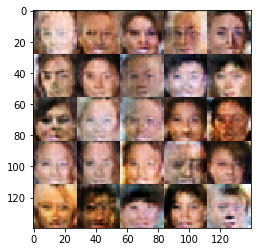

Epoch 4811/1... Discriminator Loss: 1.4447... Generator Loss: 0.9503
Epoch 4821/1... Discriminator Loss: 1.4338... Generator Loss: 0.9148
Epoch 4831/1... Discriminator Loss: 1.4061... Generator Loss: 0.6994
Epoch 4841/1... Discriminator Loss: 1.4030... Generator Loss: 0.7121
Epoch 4851/1... Discriminator Loss: 1.3878... Generator Loss: 0.8004
Epoch 4861/1... Discriminator Loss: 1.4054... Generator Loss: 0.8426
Epoch 4871/1... Discriminator Loss: 1.4045... Generator Loss: 0.8356
Epoch 4881/1... Discriminator Loss: 1.4118... Generator Loss: 0.7431
Epoch 4891/1... Discriminator Loss: 1.3993... Generator Loss: 0.8132
Epoch 4901/1... Discriminator Loss: 1.3965... Generator Loss: 0.7853


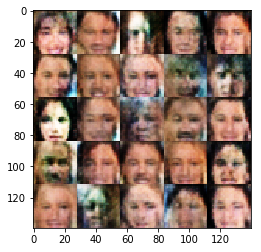

Epoch 4911/1... Discriminator Loss: 1.4014... Generator Loss: 0.7699
Epoch 4921/1... Discriminator Loss: 1.4162... Generator Loss: 0.9182
Epoch 4931/1... Discriminator Loss: 1.4430... Generator Loss: 1.0766
Epoch 4941/1... Discriminator Loss: 1.3932... Generator Loss: 0.8290
Epoch 4951/1... Discriminator Loss: 1.4051... Generator Loss: 0.9085
Epoch 4961/1... Discriminator Loss: 1.4112... Generator Loss: 0.8252
Epoch 4971/1... Discriminator Loss: 1.3978... Generator Loss: 0.7188
Epoch 4981/1... Discriminator Loss: 1.4678... Generator Loss: 0.5511
Epoch 4991/1... Discriminator Loss: 1.3929... Generator Loss: 0.7995
Epoch 5001/1... Discriminator Loss: 1.3943... Generator Loss: 0.7434


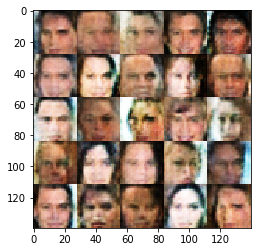

Epoch 5011/1... Discriminator Loss: 1.4056... Generator Loss: 0.6941
Epoch 5021/1... Discriminator Loss: 1.3969... Generator Loss: 0.7432
Epoch 5031/1... Discriminator Loss: 1.3940... Generator Loss: 0.7821
Epoch 5041/1... Discriminator Loss: 1.4013... Generator Loss: 0.7523
Epoch 5051/1... Discriminator Loss: 1.3938... Generator Loss: 0.8280
Epoch 5061/1... Discriminator Loss: 1.3941... Generator Loss: 0.8062
Epoch 5071/1... Discriminator Loss: 1.4045... Generator Loss: 0.7821
Epoch 5081/1... Discriminator Loss: 1.3990... Generator Loss: 0.6841
Epoch 5091/1... Discriminator Loss: 1.4153... Generator Loss: 0.6636
Epoch 5101/1... Discriminator Loss: 1.4036... Generator Loss: 0.9075


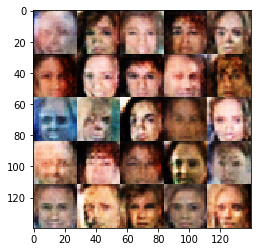

Epoch 5111/1... Discriminator Loss: 1.3895... Generator Loss: 0.7316
Epoch 5121/1... Discriminator Loss: 1.3909... Generator Loss: 0.8756
Epoch 5131/1... Discriminator Loss: 1.3981... Generator Loss: 0.7537
Epoch 5141/1... Discriminator Loss: 1.4040... Generator Loss: 0.8502
Epoch 5151/1... Discriminator Loss: 1.4105... Generator Loss: 0.9313
Epoch 5161/1... Discriminator Loss: 1.4098... Generator Loss: 0.7055
Epoch 5171/1... Discriminator Loss: 1.3872... Generator Loss: 0.8551
Epoch 5181/1... Discriminator Loss: 1.3984... Generator Loss: 0.7407
Epoch 5191/1... Discriminator Loss: 1.4083... Generator Loss: 0.7893
Epoch 5201/1... Discriminator Loss: 1.4220... Generator Loss: 0.6255


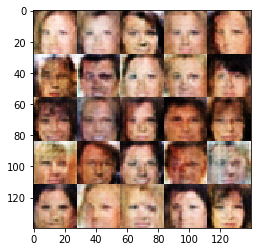

Epoch 5211/1... Discriminator Loss: 1.4259... Generator Loss: 0.6463
Epoch 5221/1... Discriminator Loss: 1.3936... Generator Loss: 0.8173
Epoch 5231/1... Discriminator Loss: 1.4053... Generator Loss: 0.8840
Epoch 5241/1... Discriminator Loss: 1.4066... Generator Loss: 0.8310
Epoch 5251/1... Discriminator Loss: 1.3927... Generator Loss: 0.8351
Epoch 5261/1... Discriminator Loss: 1.3998... Generator Loss: 0.8302
Epoch 5271/1... Discriminator Loss: 1.4237... Generator Loss: 0.6130
Epoch 5281/1... Discriminator Loss: 1.4149... Generator Loss: 0.6638
Epoch 5291/1... Discriminator Loss: 1.4009... Generator Loss: 0.8114
Epoch 5301/1... Discriminator Loss: 1.3988... Generator Loss: 0.7816


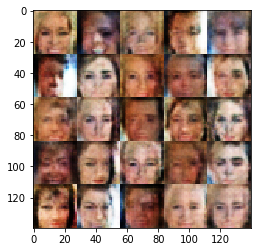

Epoch 5311/1... Discriminator Loss: 1.4195... Generator Loss: 0.8829
Epoch 5321/1... Discriminator Loss: 1.4078... Generator Loss: 0.7518
Epoch 5331/1... Discriminator Loss: 1.3890... Generator Loss: 0.8165
Epoch 5341/1... Discriminator Loss: 1.3961... Generator Loss: 0.7745
Epoch 5351/1... Discriminator Loss: 1.3920... Generator Loss: 0.7669
Epoch 5361/1... Discriminator Loss: 1.4295... Generator Loss: 0.6517
Epoch 5371/1... Discriminator Loss: 1.4092... Generator Loss: 0.6922
Epoch 5381/1... Discriminator Loss: 1.3910... Generator Loss: 0.8040
Epoch 5391/1... Discriminator Loss: 1.4049... Generator Loss: 0.9055
Epoch 5401/1... Discriminator Loss: 1.3981... Generator Loss: 0.8609


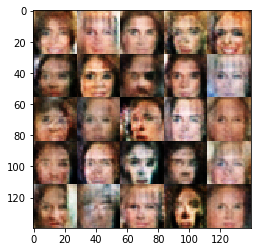

Epoch 5411/1... Discriminator Loss: 1.3819... Generator Loss: 0.7750
Epoch 5421/1... Discriminator Loss: 1.4128... Generator Loss: 0.7835
Epoch 5431/1... Discriminator Loss: 1.3918... Generator Loss: 0.7859
Epoch 5441/1... Discriminator Loss: 1.3968... Generator Loss: 0.8026
Epoch 5451/1... Discriminator Loss: 1.4224... Generator Loss: 0.8901
Epoch 5461/1... Discriminator Loss: 1.4097... Generator Loss: 0.9221
Epoch 5471/1... Discriminator Loss: 1.4081... Generator Loss: 0.8909
Epoch 5481/1... Discriminator Loss: 1.3993... Generator Loss: 0.7870
Epoch 5491/1... Discriminator Loss: 1.3991... Generator Loss: 0.7223
Epoch 5501/1... Discriminator Loss: 1.4043... Generator Loss: 0.8051


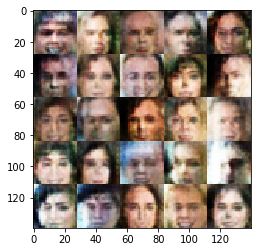

Epoch 5511/1... Discriminator Loss: 1.3880... Generator Loss: 0.8312
Epoch 5521/1... Discriminator Loss: 1.3937... Generator Loss: 0.6998
Epoch 5531/1... Discriminator Loss: 1.4179... Generator Loss: 0.6730
Epoch 5541/1... Discriminator Loss: 1.4036... Generator Loss: 0.7072
Epoch 5551/1... Discriminator Loss: 1.3905... Generator Loss: 0.7206


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.